In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import time

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Import and process the data

In [2]:
# import dataset (comes with colab!)
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

# extract labels (number IDs) and remove from data
labels = data[:,0]
data   = data[:,1:]

# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

In [3]:
# Step 1: convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long()

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)

# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

# Create the DL model

In [4]:
# create a class for the model
def createTheMNISTNet():

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)

      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return self.output(x)

  # create the model instance
  net = mnistNet()

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer (using SGD to slow down learning!)
  optimizer = torch.optim.SGD(net.parameters(),lr=.001)

  return net,lossfun,optimizer

# Brief inspection of requires_grad

In [25]:
# inspect the "learning toggle" of a layer
N = createTheMNISTNet()
N[0].input.bias

Parameter containing:
tensor([-0.0023,  0.0276, -0.0355,  0.0146, -0.0059,  0.0137, -0.0281,  0.0163,
        -0.0246,  0.0073,  0.0132, -0.0350, -0.0178,  0.0154,  0.0069, -0.0163,
         0.0127, -0.0266, -0.0028,  0.0330, -0.0015, -0.0151, -0.0150, -0.0097,
        -0.0305, -0.0325, -0.0259, -0.0083,  0.0066, -0.0148, -0.0161,  0.0276,
         0.0083, -0.0136, -0.0280,  0.0217, -0.0347, -0.0152, -0.0301,  0.0198,
        -0.0003,  0.0017, -0.0317, -0.0292, -0.0283,  0.0080,  0.0293, -0.0064,
         0.0161, -0.0295, -0.0033, -0.0044,  0.0354, -0.0002, -0.0323,  0.0201,
         0.0133,  0.0063, -0.0108, -0.0266, -0.0210, -0.0228, -0.0088,  0.0128],
       requires_grad=True)

In [26]:
N = createTheMNISTNet()[0]

# switch off all layers except input
for p in N.named_parameters():
  if 'input' not in p[0]:
    p[1].requires_grad = False


# check what we've done
for p in N.named_parameters():
  print('Requires_grad status in layer %s: %s' %(p[0],p[1].requires_grad))

Requires_grad status in layer input.weight: True
Requires_grad status in layer input.bias: True
Requires_grad status in layer fc1.weight: False
Requires_grad status in layer fc1.bias: False
Requires_grad status in layer fc2.weight: False
Requires_grad status in layer fc2.bias: False
Requires_grad status in layer output.weight: False
Requires_grad status in layer output.bias: False


# Create a function that trains the model

In [35]:
for p in net.named_parameters():
  print(p[0])

input.weight
input.bias
fc1.weight
fc1.bias
fc2.weight
fc2.bias
output.weight
output.bias


In [43]:
def function2trainTheModel(net,lossfun,optimizer):

  # number of epochs
  numepochs = 100

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):




    # NEW: switch off learning in all-but-output layers during first 1/2 of training
    # if epochi>(numepochs/2):
    #   for p in net.named_parameters():
    #     if 'output' not in p[0]:
    #       p[1].requires_grad = False
    # else:
    #   for p in net.named_parameters():
    #     p[1].requires_grad = True

    # Turn off the weights and turn on the bias
    for p in net.named_parameters():
      if 'fc2' not in p[0]:
        p[1].requires_grad = False
      else:
        p[1].requires_grad = True



    # loop over training data batches
    net.train()
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)

    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )
  # end epochs

  # function output
  return trainAcc,testAcc,losses,net

# Let's see it in action!

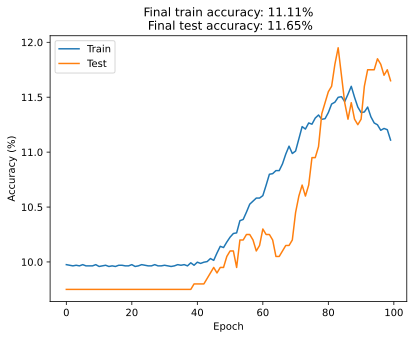

In [47]:
# create the network
net,lossfun,optimizer = createTheMNISTNet()

# train the model
trainAcc,testAcc,losses,net = function2trainTheModel(net,lossfun,optimizer)

plt.plot(trainAcc,label='Train')
plt.plot(testAcc,label='Test')
# plt.plot([len(trainAcc)/2, len(trainAcc)/2],[10,80],'k--',label='Learning switched on')
plt.title(f'Final train accuracy: {trainAcc[-1]:.2f}%\n Final test accuracy: {testAcc[-1]:0.2f}%')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

# Additional explorations

In [ ]:
# 1) Switch off all the weights, but leave all the biases switched on. Can the model still learn (at least, better than
#    chance level)? Then do the opposite: let the weights learn but turn off learnign in the biases. How does the model
#    perform now, and what does this tell you about weights vs. biases?
#
# 2) Freeze only one layer, e.g., layer fc1 (freeze both the weights and biases). Store the accuracy output as a separate
#    variable, so you run the network again without freezing anything. Then plot the accuracies (with and without
#    freezing) on the same graph. How important is fc1 based on this plot?
#